In [443]:
import numpy as np
from collections import Counter
import pandas as pd
import random
from time import time
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import UnivariateSpline

In [444]:
class Num(float):
    counts = Counter(mul=0, add=0, div=0)

    def __add__(self, other):
        self.counts["add"] += 1
        return Num(super(Num, self).__add__(other))

    def __mul__(self, other):
        self.counts["mul"] += 1
        return Num(super(Num, self).__mul__(other))

    def __sub__(self, other):
        self.counts["add"] += 1
        return Num(super(Num, self).__sub__(other))

    def __truediv__(self, other):
        self.counts["div"] += 1
        return Num(super(Num, self).__truediv__(other))

    def reset_counter(self):
        self.counts["mul"] = 0
        self.counts["add"] = 0
        self.counts["div"] = 0

In [445]:
def matrix_partition(A):
    n = A.shape[0] // 2
    m = A.shape[1] // 2
    A11 = A[:n, :m]
    A12 = A[:n, m:]
    A21 = A[n:, :m]
    A22 = A[n:, m:]
    return A11, A12, A21, A22

def matrix_repartition(A11, A12, A21, A22):
    C = np.block([[A11, A12],
                  [A21, A22]])
    return C


def compare(A, B):
    return np.allclose(np.array(A, dtype=float), np.array(B, dtype=float), rtol=1e-05,
                           atol=1e-08, equal_nan=False)\

def create_M_2(n):
    n = 2 ** n
    return np.array([[Num((random.uniform(0.00000001, 1))) for _ in range(n)] for _ in range(n)], dtype=Num)

def create_M(n):
    return np.array([[Num((random.uniform(0.00000001, 1))) for _ in range(n)] for _ in range(n)], dtype=Num)
def reset_counter():
    Num().reset_counter()

In [446]:
def inverse(A):
    if A.shape[0] == 1:
        if A[0][0] != 0:
            return np.array([[Num(1)/A[0][0]]], dtype=Num)
        return np.array([[A[0][0]]], dtype=Num)
    A11, A12, A21, A22 = matrix_partition(A)
    A11_i = inverse(A11)
    S22 = A22 - A21 @ A11_i @ A12
    S22_i = inverse(S22)
    B11 = A11_i @ (np.eye(A11_i.shape[0], dtype=Num) + A12 @ S22_i @ A21 @ A11_i)
    B12 = -A11_i @ A12 @ S22_i
    B21 = -S22_i @ A21 @ A11_i
    B22 = S22_i
    return matrix_repartition(B11, B12, B21, B22)

def check_inverse(A):
    return compare(inverse(A), np.linalg.inv(np.array(A, dtype=float)))


A = create_M(7)
print(check_inverse(A))

True


In [447]:
def LU(A):
    if A.shape[0] == 1:
        return np.array(A, dtype=Num), np.array([[1]], dtype=Num)
    A11, A12, A21, A22 = matrix_partition(A)
    L11, U11 = LU(A11)
    U11_i = inverse(U11)
    L21 = A21 @ U11_i
    L11_i = inverse(L11)
    U12 = L11_i @ A12
    S = A22 - A21 @ U11_i @ L11_i @ A12
    Ls, Us = LU(S)
    U22 = Us
    L22 = Ls
    return [matrix_repartition(L11, np.zeros((L11.shape[0], L22.shape[1]), dtype=Num), L21, L22),
            matrix_repartition(U11, U12, np.zeros((U22.shape[0], U11.shape[1]), dtype=Num), U22)]

def check_LU(A):
    L, U = LU(A)
    return compare(L, np.tril(L)) and compare(U, np.triu(U)) and compare(A, L @ U)


A = create_M(8)
L, U = LU(A)
print(check_LU(A))

True


In [448]:
def determinant(A):
    L, U = LU(A)
    return np.prod([L[i][i] for i in range(L.shape[0])]) * np.prod([U[i][i] for i in range(U.shape[0])])

def check_determinant(A):
    return compare(determinant(A), np.linalg.det(np.array(A, dtype=float)))

print(check_determinant(A))

True


In [449]:
def test_functions(bound):
    df = pd.DataFrame()
    for n in range(2, bound):
        A = create_M(n)
        methods = {"Inverse":inverse, "LU":LU, "Determinant":determinant}
        checks = [check_inverse, check_LU, check_determinant]
        i = 0
        for method_name, method in methods.items():
            print(n, method_name[0], end=" ")
            df.at[n, method_name] = checks[i](A)
            i += 1
    return df

In [450]:
test_functions(10)

2 I 2 L 2 D 3 I 3 L 3 D 4 I 4 L 4 D 5 I 5 L 5 D 6 I 6 L 6 D 7 I 7 L 7 D 8 I 8 L 8 D 9 I 9 L 9 D 

,Inverse,LU,Determinant
2,True,True,True
3,True,True,True
4,True,True,True
5,True,True,True
6,True,True,True
7,True,True,True
8,True,True,True
9,True,True,True


In [451]:
def stat_functions(bound, step=1):
    df_times = pd.DataFrame()
    df_add = pd.DataFrame()
    df_mul = pd.DataFrame()
    df_div = pd.DataFrame()
    for n in range(1, bound, step):
        A = create_M(n)
        methods = {"Inverse":inverse, "LU":LU, "Determinant":determinant}
        for method_name, method in methods.items():
            reset_counter()
            print(n, method_name[0], end=" ")
            start_time = time()
            method(A)
            df_times.at[n, method_name] = time() - start_time
            df_add.at[n, method_name] = Num().counts["add"]
            df_mul.at[n, method_name] = Num().counts["mul"]
            df_div.at[n, method_name] = Num().counts["div"]
    return df_times, df_add, df_mul, df_div

In [452]:
dfs = stat_functions(100, 5)

1 I 1 L 1 D 6 I 6 L 6 D 11 I 11 L 11 D 16 I 16 L 16 D 21 I 21 L 21 D 26 I 26 L 26 D 31 I 31 L 31 D 36 I 36 L 36 D 41 I 41 L 41 D 46 I 46 L 46 D 51 I 51 L 51 D 56 I 56 L 56 D 61 I 61 L 61 D 66 I 66 L 66 D 71 I 71 L 71 D 76 I 76 L 76 D 81 I 81 L 81 D 86 I 86 L 86 D 91 I 91 L 91 D 96 I 96 L 96 D 

In [453]:
def plot_stats(dfs):
    titles = ["Methods' times comparison", "Methods' addition counts comparison", "Methods' multiplication counts comparison",  "Methods' division counts comparison"]
    y_labels = ["Time [s]", "Addition count", "Multiplication count", "Division count"]
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 30))
    i = 0
    for df, title, y_label in zip(dfs, titles, y_labels):

        # Polynomial interpolation and plotting
        plt.figure(figsize=(10, 6))
        sns.set(style="whitegrid")
        ax = axes[i]
        for method in df.columns:
            x = df.index
            y = df[method]


            y=y.dropna(how='all')
            x=x.dropna(how='all')[:len(y)]
            # print(x)
            # print(y)


            # Polynomial interpolation
            # coefficients = np.polyfit(x, y, len(x) - 1)
            # polynomial = np.poly1d(coefficients)
            #
            # # Generate interpolated x values
            # x_interp = np.linspace(min(x), max(x), 100)
            #
            # # Plot the interpolated curve
            # ax.plot(x_interp, polynomial(x_interp), label=method)
            # ax.scatter(x, y)
            spline = UnivariateSpline(x, y, s=0)
            x_interp = np.linspace(min(x), max(x), 100)
            y_interp = spline(x_interp)

            # Plot the interpolated curve
            ax.plot(x_interp, y_interp, label=method)
            ax.scatter(x, y)

            s = " (Matrices of sizes 2^x $\\times$ 2^x)"
            ax.set_xlabel('Size od matrices ($\log_2$ scale)' + s)
            ax.set_ylabel(y_label)
            ax.set_title(title)

            # Show legend
            ax.legend()
        i += 1

    plt.show()


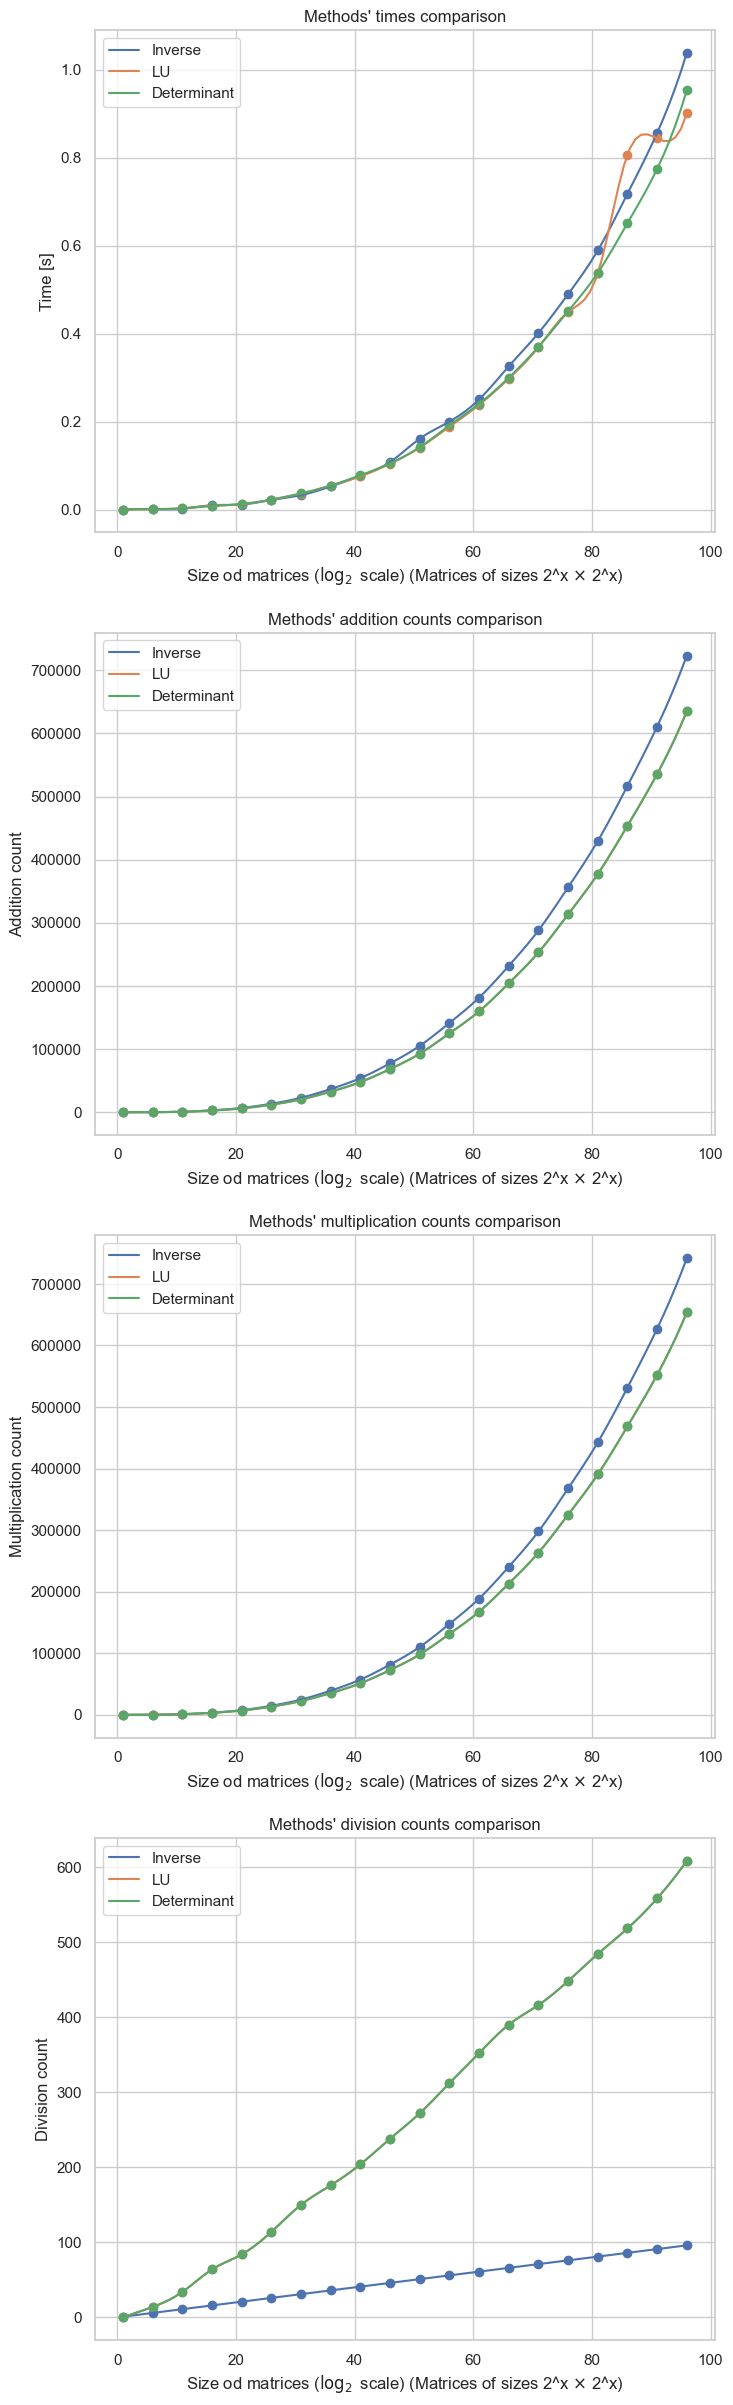

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [454]:
plot_stats(dfs)